In [365]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
Bernoulli = tf.contrib.distributions.Bernoulli

### Utilitiy functions

In [366]:
def plot_banded_error(errs, label, ax=None):
    ax = ax or plt
    m = np.mean(errs, axis=0)
    s = np.std(errs, axis=0)
    line, = ax.plot(np.arange(1, len(m)+1), m, '.-', label=label)
  #  ax.fill_between(np.arange(1, len(m)+1), m-s, m+s, color=line.get_color(), alpha=0.075)

def fatlegend(ax, *a, **kw):
    leg = ax.legend(*a, **kw)
    for l in leg.legendHandles:
        l.set_linewidth(l.get_linewidth()*2.0)
    return leg

def add_layer(inputs, wn, bn, in_dim, out_dim, af=None):
    try:
        w = tf.get_variable(wn, [in_dim, out_dim], initializer=tf.truncated_normal_initializer)
        b = tf.get_variable(bn, [1, out_dim], initializer=tf.truncated_normal_initializer)
    except:
        with tf.variable_scope(tf.get_variable_scope(), reuse=True):
            w = tf.get_variable(wn)
            b = tf.get_variable(bn)
    if af is None:
        return tf.matmul(inputs, w) + b
    return af(tf.matmul(inputs, w) + b)

def get_weights(wn, bn):
    with tf.variable_scope(tf.get_variable_scope(), reuse=True):
        w = tf.get_variable(wn)
        b = tf.get_variable(bn)
    return [w,b]

def log_prob(p, s):
    return tf.log(tf.clip_by_value(s*p+(1.0-s)*(1.0-p), eps, 1-eps))

def det_pass(inputs, layer, n=1):
    if layer==1:
        z = add_layer(inputs, "whh", "bhh", nh, nh, tf.nn.sigmoid)
        inputs = z
    z = add_layer(inputs, "why", "bhy", nh, 392, tf.nn.sigmoid)
    z = z*tf.tile(y_,[n,1])+(1-z)*(1-tf.tile(y_,[n,1]))
    return tf.reduce_sum(z/tf.tile(-y_expect-eps,[n,1]), 1, keep_dims=True)

### Parameters

In [367]:
batch_size = 10
ns = 10
lr = 1e-3
eps = 1e-7
alpha = 0.9
steps = 50000
nh = 100

### Sigmoid belief networks

In [368]:
x = tf.placeholder(tf.float32, [None, 392])
h = add_layer(x, "wxh", "bxh", 392, nh, tf.nn.sigmoid)
sh = tf.stop_gradient(tf.reshape(Bernoulli(probs=h, dtype=tf.float32).sample(ns), [ns*batch_size, nh]))
h2 = tf.reduce_mean(tf.reshape(add_layer(sh, "whh", "bhh", nh, nh, tf.nn.sigmoid), [ns, batch_size, nh]), 0)
sh2 = tf.stop_gradient(tf.reshape(Bernoulli(probs=h2, dtype=tf.float32).sample(ns), [ns*batch_size, nh]))
y = add_layer(sh2, "why", "bhy", nh, 392, tf.nn.sigmoid)
y_ = tf.placeholder(tf.float32, [None, 392])

yy = y*tf.tile(y_,[ns,1])+(1-y)*(1-tf.tile(y_,[ns,1]))
y_expect = tf.reduce_mean(tf.reshape(yy, [ns, batch_size, 392]), 0)

nll = tf.reduce_mean(tf.reduce_sum(-tf.log(tf.clip_by_value(y_expect, eps, 1-eps)), 1))
ls = tf.reduce_sum(yy/(tf.tile(-y_expect-eps, [ns,1])), 1, keep_dims=True)

#saver = tf.train.Saver()

### Gradient estimators

In [399]:
bsln = tf.placeholder(tf.float32)
bslnv = tf.placeholder(tf.float32)
opt = tf.train.AdamOptimizer(lr)

def gd_est(md, linear=True):
    func = {
        0: lambda: [tf.tile(tf.reduce_mean(tf.reshape(ls,[ns,batch_size,1]),0),[ns,1]),ls]+[tf.zeros([ns*batch_size,1])]*2+[tf.constant([0.])]*4+[None],
        1: muProp,
        2: DARN,
        3: baseline,
        4: NVIL
    }
    f, f2, g, g2, mg, mg2, m, v, tr = func.get(md)()
    dy = opt.compute_gradients(nll, get_weights("why", "bhy"))    
    if linear:        
        dh2 = opt.compute_gradients(tf.reduce_mean(tf.stop_gradient(f2-g2)*log_prob(tf.tile(h2, [ns,1]), sh2), 0) + 
                                    tf.reduce_mean(mg2, 0), get_weights("whh", "bhh"))        
        dh  = opt.compute_gradients(tf.reduce_mean(tf.stop_gradient(f-g)*log_prob(tf.tile(h, [ns,1]), sh), 0) + 
                                    tf.reduce_mean(mg, 0), get_weights("wxh", "bxh"))
    else:
        dh2 = opt.compute_gradients(tf.reduce_mean(tf.stop_gradient(f2/g2)*mg2, 0), 
                                    get_weights("whh", "bhh"))        
        dh = opt.compute_gradients(tf.reduce_mean(tf.stop_gradient(f/g)*mg, 0), 
                                   get_weights("wxh", "bxh"))
        
    train_step = opt.apply_gradients(dy+dh2+dh if tr is None else dy+dh2+dh+tr)
    return train_step, y_expect, nll, m, v

def muProp():    
    fh = det_pass(h, 1)
    dfh = tf.gradients(fh, h)[0]
    coef = cv_coef(fh, dfh, h, 1, get_weights("wxh", "bxh"), False)
    mg = tf.stop_gradient(coef*dfh)*h    
    fh, dfh = [tf.tile(z, [ns,1]) for z in [fh, dfh]]
    g = coef*(fh+tf.reduce_sum(dfh*(sh-tf.tile(h, [ns,1])), 1, keep_dims=True))
 
    fh2 = det_pass(h2, 2)
    dfh2 = tf.gradients(fh2, h2)[0]
    coef2 = cv_coef(fh2, dfh2, h2, 2, get_weights("whh", "bhh"), False)         
    mg2 = tf.stop_gradient(coef2 * dfh2) * h2
    fh2, dfh2 = [tf.tile(z,[ns,1]) for z in [fh2, dfh2]]
    g2 = coef2 * (fh2+tf.reduce_sum(dfh2*(sh2-tf.tile(h2,[ns,1])),1,keep_dims=True))
    
    f = tf.tile(tf.reduce_mean(tf.reshape(ls,[ns,batch_size,1]),0),[ns,1])
    return f, ls, g, g2, mg, mg2, tf.constant(0.), tf.constant(0.), None
        
def cv_coef(cfh, cdh, p, layer, w, cf):
    if not cf:
        return 1.    
    nn = 10
    ss = tf.stop_gradient(tf.reshape(Bernoulli(probs=p, dtype=tf.float32).sample(nn), [nn*batch_size, nh]))
    sfh = det_pass(ss, layer, nn)
        
    cfh, cdh, hh = [tf.tile(z, [nn,1]) for z in [cfh, cdh, p]]
    f = tf.stop_gradient(sfh)*log_prob(hh, ss)
    g = tf.stop_gradient(cfh+tf.reduce_sum(cdh*(ss-hh), 1, keep_dims=True))*log_prob(hh, ss)
        
    df, dg = [tf.gradients(tf.reduce_mean(z, 0), w) for z in [f,g]]
    mf, mg = [tf.concat([z[0], z[1]], 0) for z in [df, dg]]
    f, g = [tf.reshape(z, [nn, batch_size, nh]) for z in [f,g]]
    for i in range(nn):
        df, dg = [tf.gradients(tf.reduce_mean(z[i], 0), w) for z in [f, g]]
        df, dg = [tf.concat([z[0], z[1]], 0) for z in [df, dg]]
        vg = tf.square(dg-mg) if i==0 else vg+tf.square(dg-mg)
        cov = (df-mf)*(dg-mg) if i==0 else cov+(df-mf)*(dg-mg)
    return tf.reduce_sum(cov)/tf.reduce_sum(vg)

def gd_var(f, g, mg, dh):
    mest = tf.concat([dh[0][0], dh[1][0]], 0)
    f, g = [tf.reshape(z,[ns,batch_size,1]) for z in [f,g]]
    _sh = tf.reshape(sh,[ns,batch_size,200])
    for i in range(ns):
        esti = tf.gradients(tf.reduce_mean(tf.stop_gradient(f[i]-g[i])*log_prob(_sh[i],h) + mg,0),
                            get_weights("wxh", "bxh", 392, 200))
        esti = tf.concat([esti[0],esti[1]],0)
        v = tf.square(esti-mest) if i==0 else v+tf.square(esti-mest)
    return tf.reduce_mean(v/(ns-1))

def DARN():
    dh = tf.gradients(loss, sh)[0]
    g = tf.stop_gradient(loss + dh*(0.5-sh))
    return tf.stop_gradient(loss), g, tf.constant(0.), tf.constant(0.), tf.constant(0.), None

def baseline():
    b = alpha*bsln + (1.0-alpha)*tf.reduce_mean(ls)
    g = tf.stop_gradient(b) * p
    f = tf.stop_gradient(loss) * p
    return f, g, tf.constant(0.), b, tf.constant(0.), None

def NVIL():
    ch = add_layer(x, "wh", "bh", 392, 100, tf.tanh)
    cy = add_layer(ch, "wy", "by", 100, 1)
    b = alpha*bsln + tf.reduce_mean((1.0-alpha)*(loss-cy))
    vv = tf.reduce_mean(tf.square(loss-cy-tf.reduce_mean(loss-cy)))/tf.maximum(1.0, (ns-1))
    v = alpha*bslnv + (1.0-alpha)*vv
    g = tf.stop_gradient((cy+b)/tf.maximum(1.0,tf.sqrt(v))) * p
    f = tf.stop_gradient(loss/tf.maximum(1.0,tf.sqrt(v))) * p
    tr = opt.compute_gradients(tf.reduce_mean(tf.square(tf.stop_gradient(loss-b)-cy)), 
                               [get_weights("wh", "bh", 392, 100), get_weights("wy", "by", 100, 1)])
    return f, g, None, tr, b, v

def ST_():
    train_step = tf.train.AdamOptimizer(lr).minimize(nll)
    return train_step, nll, tf.constant(0.), tf.constant(0.)

In [400]:
def train(train_op):
    with tf.Session() as sess:
        data = input_data.read_data_sets("MNIST_data/", one_hot=True).test
        data.images[data.images>0.5] = 1.0
        data.images[data.images<=0.5] = 0.0
        bl = 0.
        vr = 0.
        ll = np.empty((1000, steps/1000))
        vv = np.empty((1000, steps/1000))        
        sess.run(tf.global_variables_initializer())

        for i in range(steps):
            batch_ = data.next_batch(batch_size, shuffle=False)[0]
            batch_xs = batch_[:,0:392]
            batch_ys = batch_[:,392:784]

            res = sess.run(train_op, {x: batch_xs, y_: batch_ys, bsln: bl, bslnv: vr})
            bl = res[-2]
            vr = res[-1]   
            ll[i%1000, i/1000] = res[-3]
#            vv[i%1000, i/1000] = res[0]
            if (i+1)%1000==0:
                print (i+1)/1000, np.mean(ll[:, i/1000], 0), res[0],
#                print np.mean(vv[:, i/1000], 0),                

#        save_path = saver.save(sess, "model/model.ckpt")
    return ll, vv, batch_xs, batch_ys, res[1]

In [401]:
#train_op = ST_()
train_op = gd_est(1, True)
result = train(train_op)
mpr_10_10_3t_origin = result[0]

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
1 184.751265038 None 2 119.505410728 None 3 111.372555405 None 4 105.880124161 None 5 101.597053406 None 6 98.225517067 None 7 95.6279541168 None 8 93.7881262741 None 9 92.3088631325 None 10 91.2264249992 None 11 90.2261293526 None 12 89.3579541855 None 13 88.637077301 None 14 88.0412284546 None 15 87.4461331329 None 16 86.950303894 None 17 86.3487333755 None 18 85.9950865211 None 19 85.5070887718 None 20 85.04989571 None 21 84.6750107117 None 22 84.5078482094 None 23 84.3303532066 None 24 84.0714176064 None 25 83.8110996361 None 26 83.4379471779 None 27 83.0365274315 None 28 82.7312996178 None 29 82.4493115883 None 30 82.2233361053 None 31 82.0285173683 None 32 81.7322895088 None 33 81.7166696014 None 34 81.3195919876 None 35 81.206052845 None 36 81.0302809677 None 37 80.9520004883 None 38 80.6

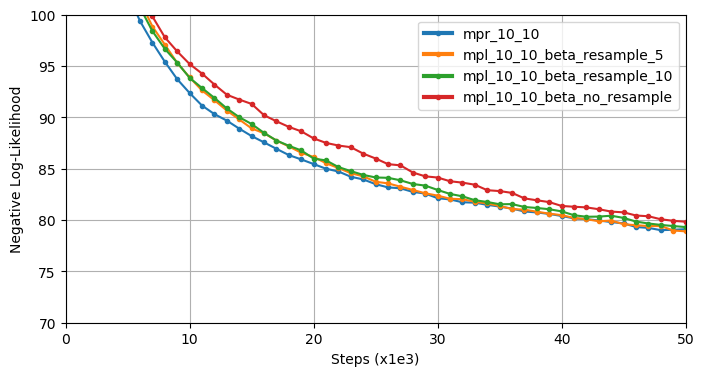

In [404]:
plt.style.use('default')
fig, ax = plt.subplots(1,1, figsize=(8,4))
plt.xlim(0, 50)
plt.ylim(70,100)

#plot_banded_error(lhr_10_1, "lhr_10_1")
#plot_banded_error(lhr_10_10, "lhr_10_10")

#plot_banded_error(mpl_10_1, "mpl_10_1")
#plot_banded_error(mpl_10_1_beta, "mpl_10_1_beta")

plot_banded_error(mpr_10_10_2t, "mpr_10_10")
plot_banded_error(mpl_10_10_beta, "mpl_10_10_beta_resample_5")
plot_banded_error(mpr_10_10_beta_resample, "mpl_10_10_beta_resample_10")
plot_banded_error(mpr_10_10_beta_no_resample, "mpl_10_10_beta_no_resample")

fatlegend(ax)
plt.ylabel("Negative Log-Likelihood")
plt.xlabel("Steps (x1e3)")
ax.grid(True)
plt.show()
#fig.savefig('foo.png')

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
up = np.concatenate([j for j in [np.reshape(i,[14,28]) for i in result[1]]], 1)
dw = np.concatenate([j for j in [np.reshape(i,[14,28]) for i in result[2]]], 1)
p1 = np.concatenate(np.split(np.concatenate([up,dw], 0), batch_size/10, 1), 0)
dwy = np.concatenate([j for j in [np.reshape(i,[14,28]) for i in result[3]]], 1)
p2 = np.concatenate(np.split(np.concatenate([up,dwy], 0), batch_size/10, 1), 0)
ax[0].imshow(p1, cmap=plt.cm.gray, interpolation='none')
ax[1].imshow(p2, cmap=plt.cm.gray, interpolation='none')
ax[0].grid(False)
ax[1].grid(False)
plt.show()

In [388]:
def muProp(f, p, s, layer, w, cf):
    fh = det_pass(p, layer)
    dfh = tf.gradients(fh, p)[0]
    coef = cv_coef(fh, dfh, p, layer, w, cf)
    mg = tf.stop_gradient(coef*dfh)*p
    fh, dfh = [tf.tile(z, [ns,1]) for z in [fh, dfh]]
    g = coef*(fh+tf.reduce_sum(dfh*(s-tf.tile(p, [ns,1])), 1, keep_dims=True))
    return g, mg